# Collaborative Filtering Methods


In [1]:
# data analysis and wrangling
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

# functions to test
from gradientDescent import gradientDescent
from alternatingLeastSquares import ALS
from lineSearchAlgorithm import lineSearch
from cost_functions import get_Ju_and_DJu, get_Ja_and_DJa
from aux_functions import initializeQ, initializeP
from accuracyMetrics import RMSE


## Sample Data

We create a simple $5\times4$ interactions matrix to test our algorithms.


In [2]:
R0 = np.array(
    [
        [5, 1, np.NAN, 4],
        [np.NAN, 9, np.NAN, 2],
        [9, 2, 1, np.NAN],
        [6, np.NAN, 7, 4],
        [np.NAN, 4, 7, 5],
    ]
)

R = R0

# Calculate the mean and standard deviation of each column (axis 0)
mean = np.nanmean(R)

# Standardize the matrix
R = R - mean

m, n = R.shape


We define the range $f$ for the matrices $Q$ and $P$ that will approximate $R$.


In [3]:
f = 5

We initialize $Q$ and $P$ with values from a standard normal random variable keeping a constant seed for consistent results.


In [4]:
# Seed
np.random.seed(43)

# Q and P initilization
Q = initializeQ(R.shape[0], f)
P = initializeP(R.shape[1], f)

## Line Search Test


In [5]:
Ju, DJu = get_Ju_and_DJu(R, P, f)
Q = Q.flatten()
p_k = -DJu(Q)
alpha = lineSearch(Ju, DJu, Q, p_k)
alpha

0.125

## Optimizing $Ju$ using Gradient Descent with Line Search


In [6]:
tol = 1e-5
max_iter = 1e4

Ju, DJu = get_Ju_and_DJu(R, P, f)

Q = Q.flatten()
gradientDescentResults = gradientDescent(Ju, Q, DJu, tol, max_iter)
newQs = gradientDescentResults["x_values"]
Ju_values = gradientDescentResults["func_values"]

Calculating errors and $RMSE$

$$RMSE = \sqrt{\frac{\sum_{(u,j)}{e_{u,j}^2}}{\lvert E \rvert}}$$


In [7]:
RMSEs = []
for Q_k in newQs:
    Q_k = Q_k.reshape(R.shape[0], -1)
    errors = (Q_k @ P.T - R).flatten()

    # Check for NaN values using np.isnan()
    is_nan = np.isnan(errors)

    # Use boolean indexing to filter out NaN values
    errors = errors[~is_nan]
    RMSEs.append(RMSE(errors))


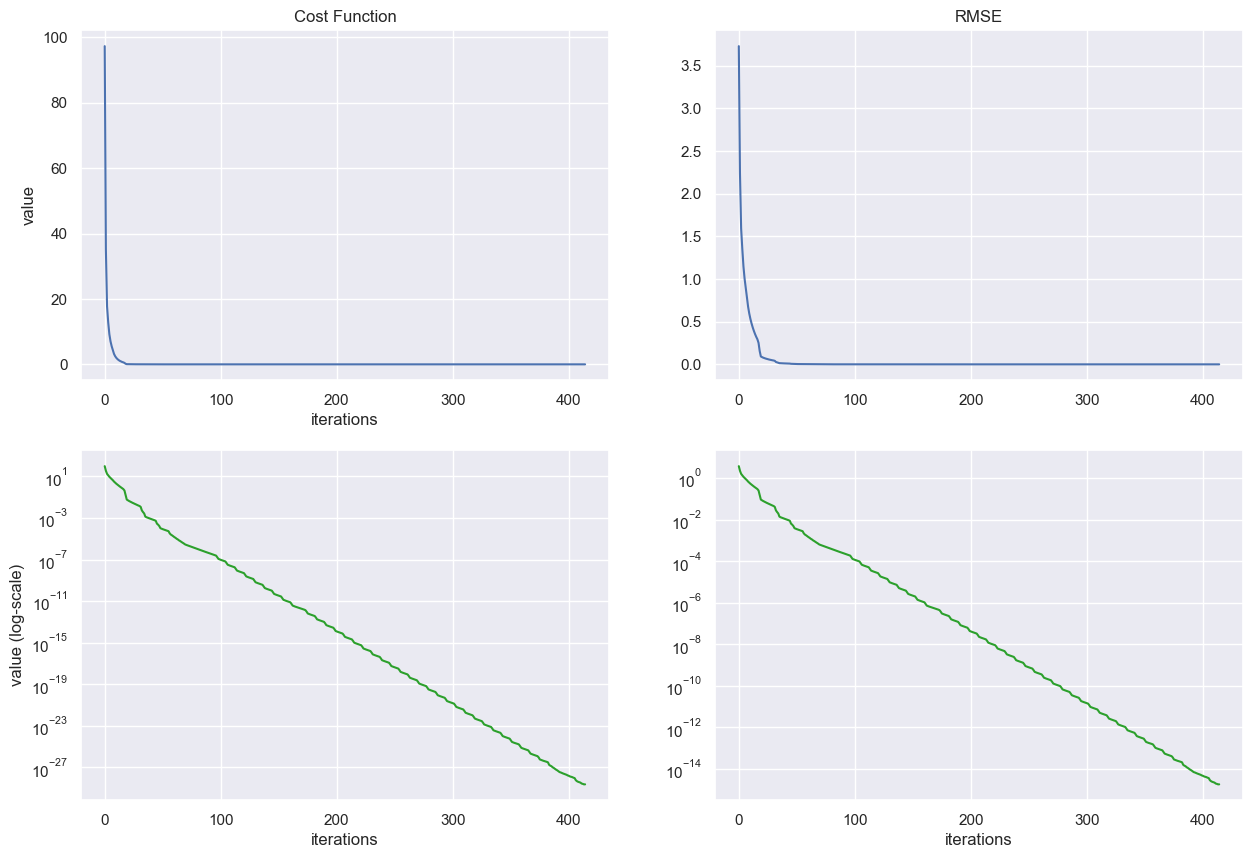

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

axs[0, 0].plot(Ju_values)
axs[0, 0].set_title("Cost Function")
axs[0, 1].plot(RMSEs)
axs[0, 1].set_title("RMSE")
axs[1, 0].semilogy(Ju_values, "tab:green")
axs[1, 1].semilogy(RMSEs, "tab:green")

axs[0, 0].set(xlabel="iterations", ylabel="value")
axs[1, 0].set(xlabel="iterations", ylabel="value (log-scale)")
axs[1, 1].set(xlabel="iterations")

plt.show()


## Testing ALS method for collaborative filtering


In [9]:
np.random.seed(43)
f = 4
alternations = 1000
tol = 1e-2
max_iter = 1e1

als_result = ALS(R, f, alternations=alternations, tol=tol, max_iter=max_iter)

In [10]:
newQ = als_result["Q"]
newP = als_result["P"]
Ju_values = als_result["Ju_values"]
Ja_values = als_result["Ja_values"]
RMSEu_values = als_result["RMSEu_values"]
RMSEa_values = als_result["RMSEa_values"]

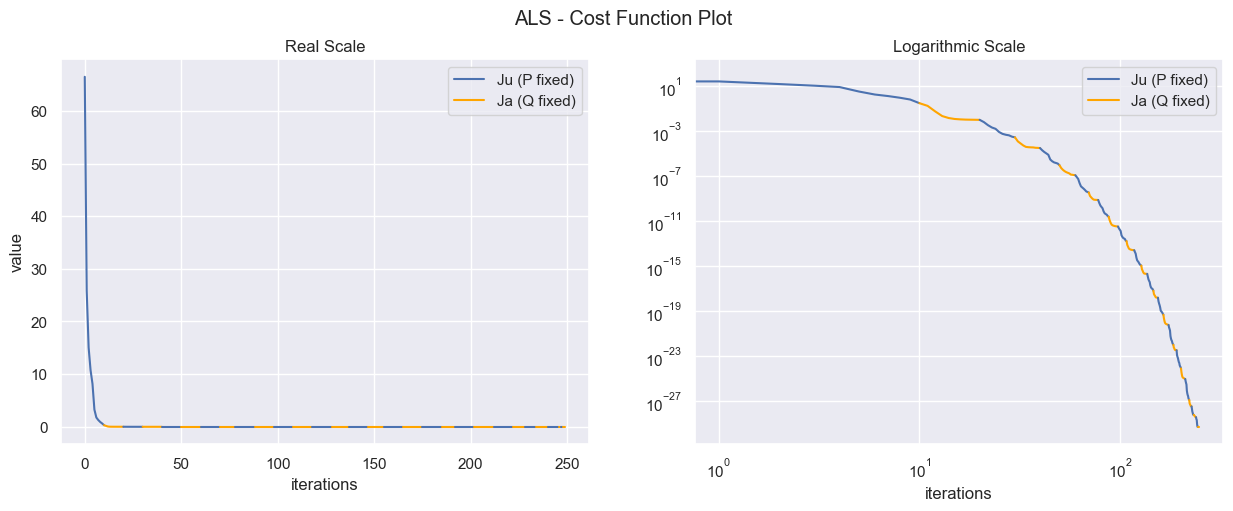

In [11]:
from plottingFunctions import plotALSResults

plotALSResults(Ju_values, Ja_values, "ALS - Cost Function Plot")


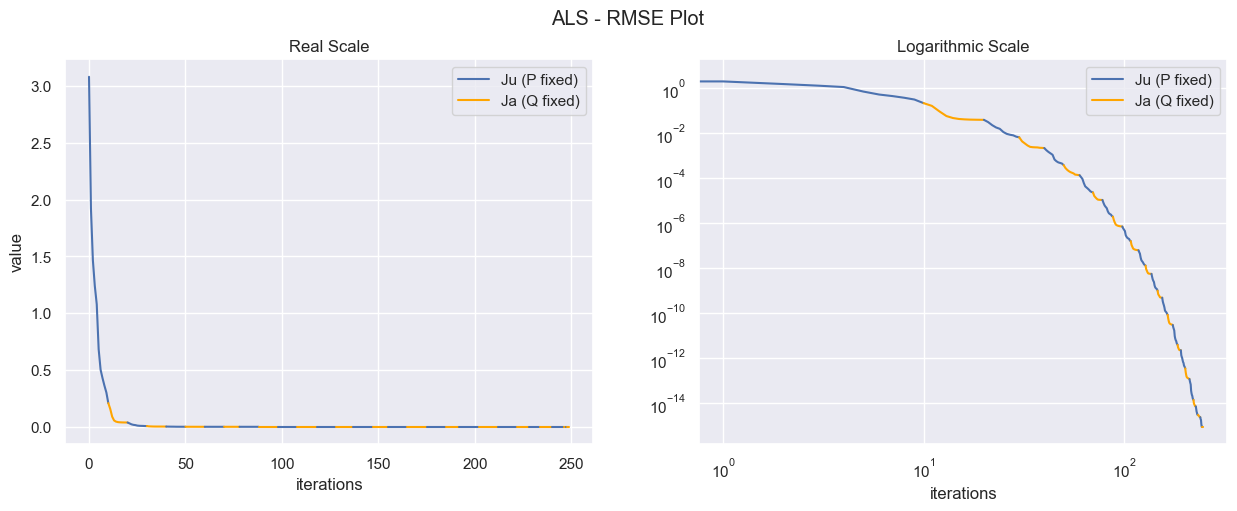

In [12]:
plotALSResults(RMSEu_values, RMSEa_values, "ALS - RMSE Plot")

## Testing Regularization


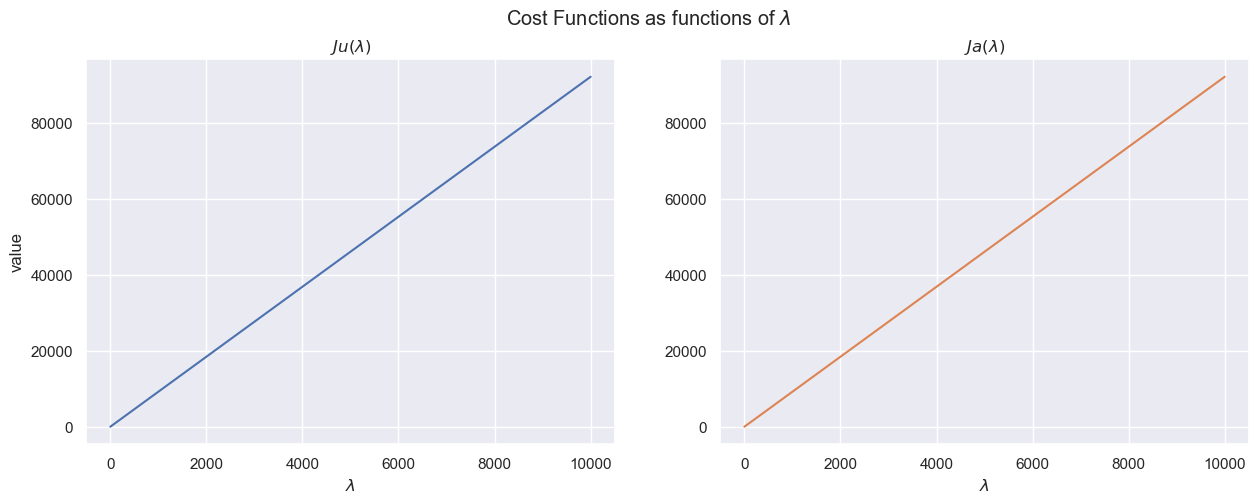

In [13]:
from plottingFunctions import plot_Ju_Ja_as_functions_of_lambda

f = 4
plot_Ju_Ja_as_functions_of_lambda(R, f)


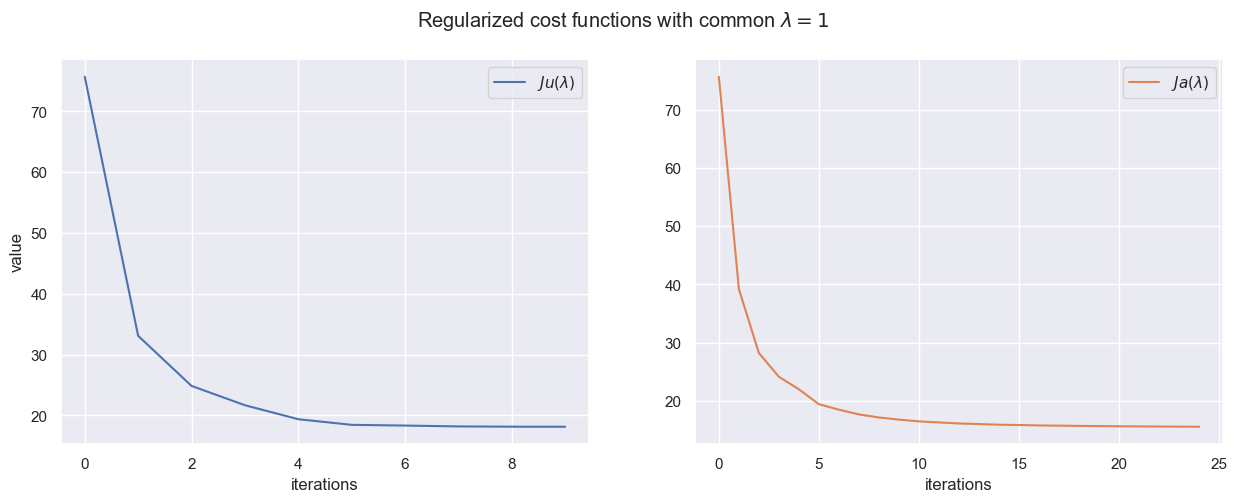

In [14]:
from plottingFunctions import plot_Ju_Ja_fixed_lamb

lamb = 1
f = 4

plot_Ju_Ja_fixed_lamb(R=R, lamb=lamb, f=f)


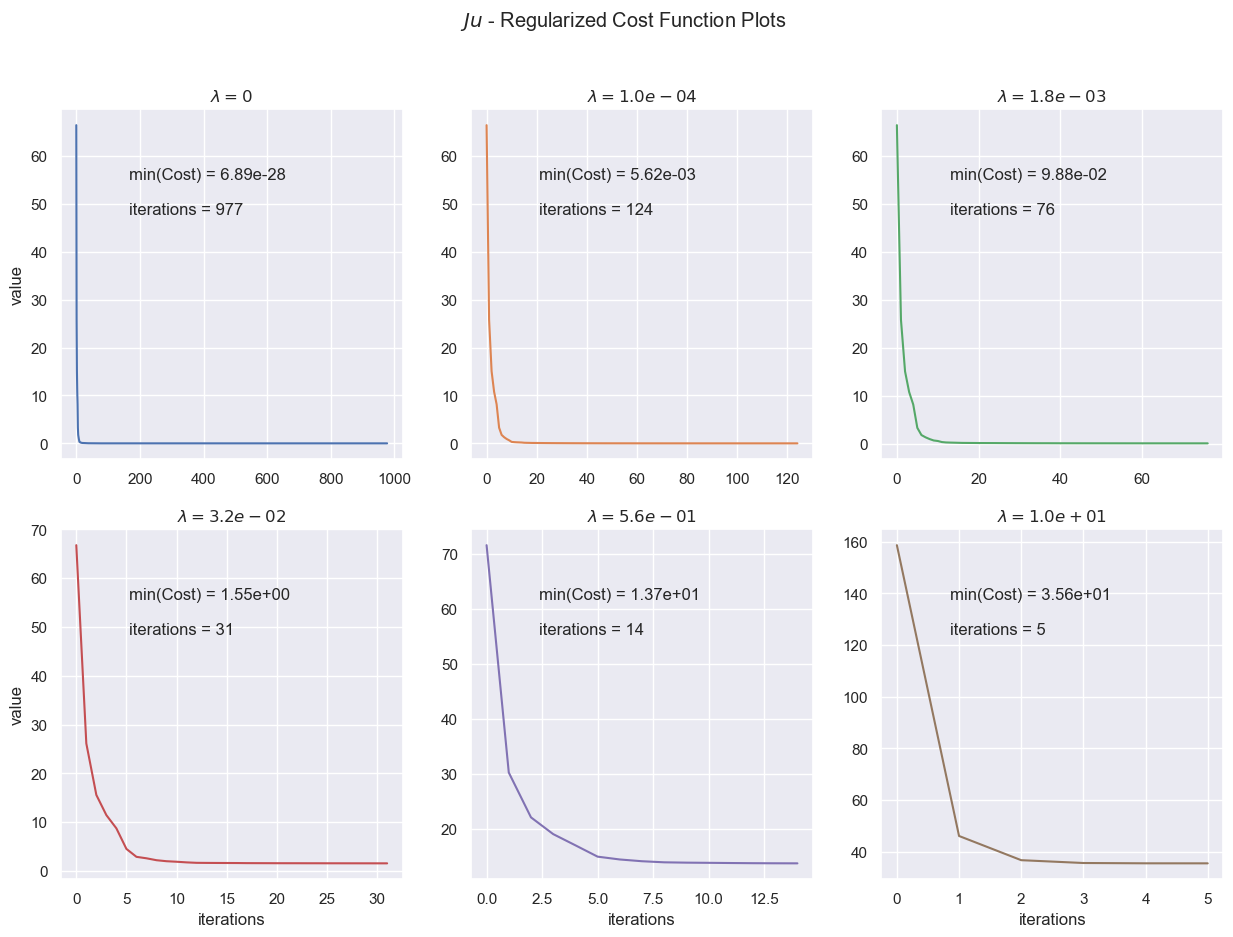

In [15]:
from plottingFunctions import plot_costFunction_with_different_lamb

lambs = np.append(0, (np.logspace(-4, 1, 5)))

np.random.seed(43)
f = 4
Q_0 = initializeQ(R.shape[0], f)
P_0 = initializeP(R.shape[1], f)

title = r"$Ju$ - Regularized Cost Function Plots"

plot_costFunction_with_different_lamb(
    R=R, f=f, X_0=Q_0, Theta=P_0, getCostFunc=get_Ju_and_DJu, lambs=lambs, title=title
)

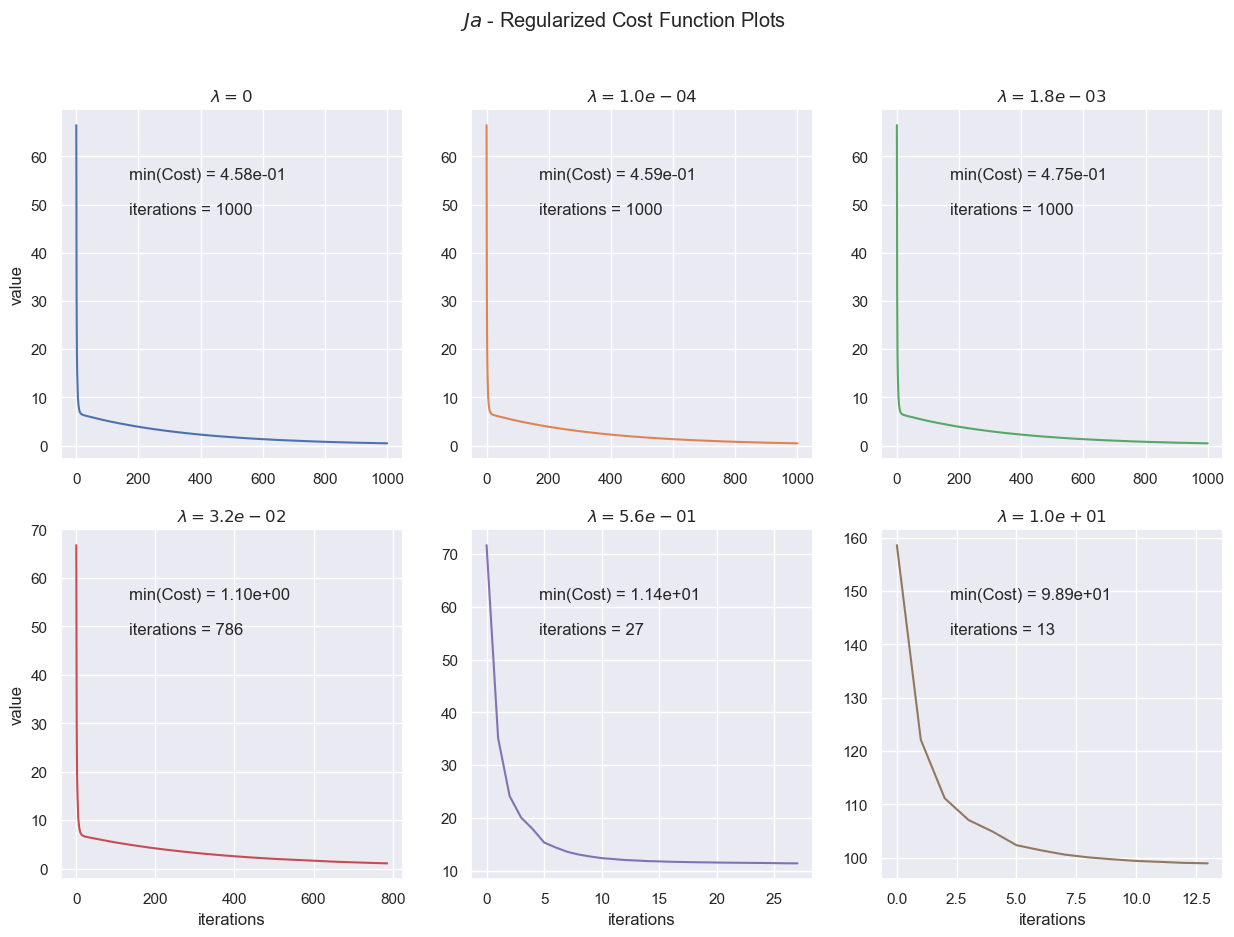

In [16]:
title = r"$Ja$ - Regularized Cost Function Plots"

plot_costFunction_with_different_lamb(
    R=R,
    f=f,
    X_0=P_0,
    Theta=Q_0,
    getCostFunc=get_Ja_and_DJa,
    lambs=lambs,
    title=title,
)

### Testing Regulirized ALS


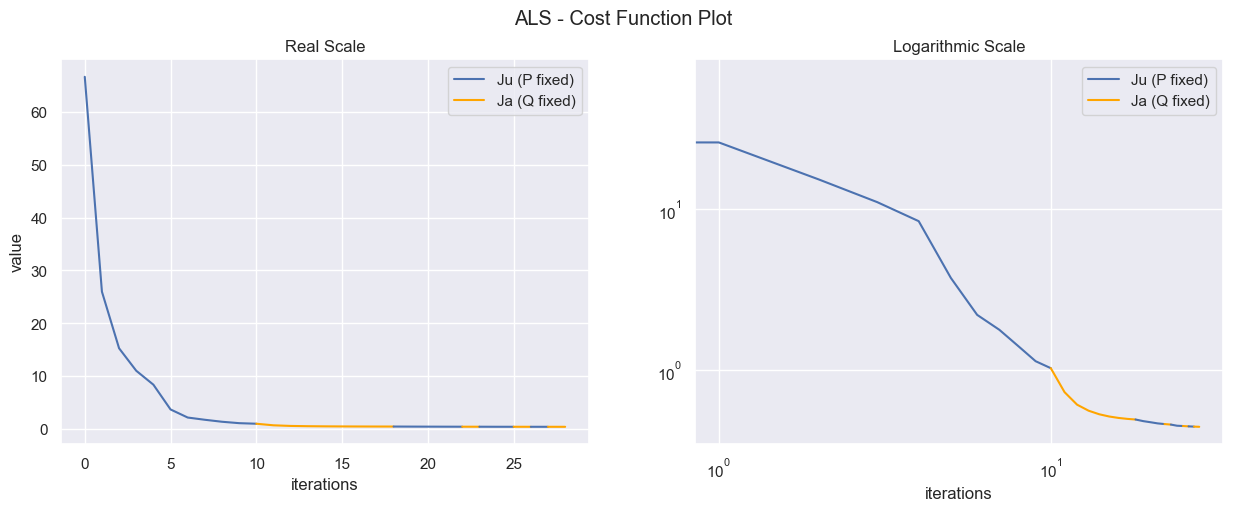

In [17]:
np.random.seed(43)

f = 4
alternations = 1000
tol = 1e-2
max_iter = 1e1
lambQ = 0.01
lambP = lambQ

als_result = ALS(
    R,
    f,
    alternations=alternations,
    tol=tol,
    max_iter=max_iter,
    lambQ=lambQ,
    lambP=lambP,
)

Ju_values = als_result["Ju_values"]
Ja_values = als_result["Ja_values"]
RMSEu_values = als_result["RMSEu_values"]
RMSEa_values = als_result["RMSEa_values"]

plotALSResults(Ju_values, Ja_values, "ALS - Cost Function Plot")


## Testing item and user biases


### Muestral biases


In [18]:
np.random.seed(43)
f = 4
Q_0 = initializeQ(R.shape[0], f)
P_0 = initializeP(R.shape[1], f)

In [19]:
alpha_0 = np.nansum(R, 1) / np.count_nonzero(~np.isnan(R), 1)
beta_0 = np.nansum(R, 0) / np.count_nonzero(~np.isnan(R), 0)

newR = alpha_0[:, np.newaxis] + beta_0
errors = newR - R
is_nan = np.isnan(errors)
errors = errors[~is_nan]
print(RMSE(errors))

2.0387404408197756


### Comparing muestral biases and parameter biases in $J_u$


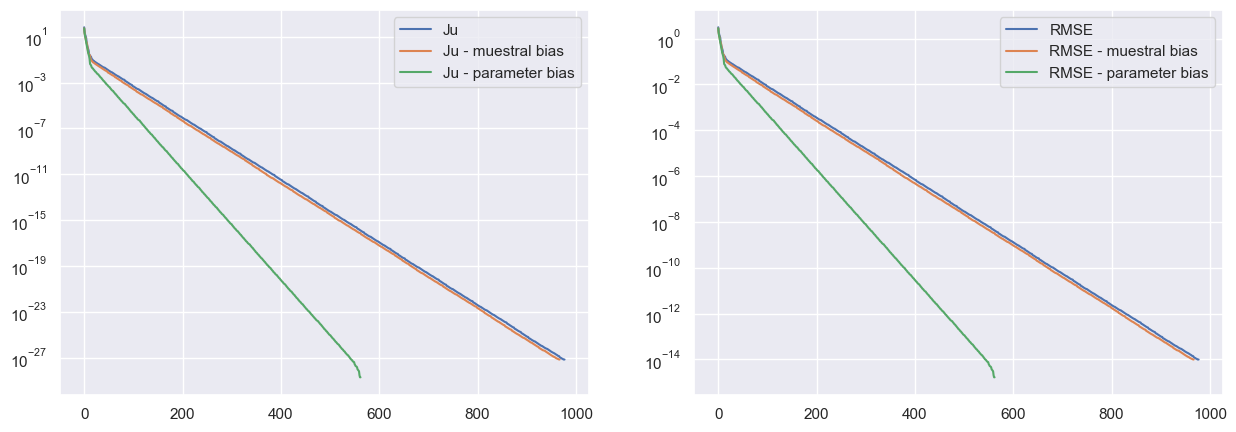

In [20]:
from alternatingLeastSquares import getRMSEs_Pfixed
from cost_functions import get_alpha, get_beta

alpha_0 = get_alpha(R)
beta_0 = get_beta(R)

tol = 1e-5
max_iter = 1e4

# Without bias
Ju, DJu = get_Ju_and_DJu(R, P_0, f)
Q_0 = Q_0.flatten()
gradientDescentResults = gradientDescent(Ju, Q_0, DJu, tol, max_iter)
newQs = gradientDescentResults["x_values"]
Ju_values = gradientDescentResults["func_values"]
RMSE_values = getRMSEs_Pfixed(newQs, P_0, R)

# With muestral bias
Ju, DJu = get_Ju_and_DJu(R, P_0, f, muestral_bias=True)
Q_0 = Q_0.flatten()
gradientDescentResults = gradientDescent(Ju, Q_0, DJu, tol, max_iter)
newQs = gradientDescentResults["x_values"]
Ju_values_muestral_biased = gradientDescentResults["func_values"]
RMSE_values_muestral_biased = getRMSEs_Pfixed(
    newQs, P_0, R, muestral_bias=True, alpha=alpha_0, beta=beta_0
)

# With parameter bias
Ju, DJu = get_Ju_and_DJu(R, P_0, f, parameter_bias=True, beta=beta_0)
Q_0 = Q_0.flatten()
Theta = np.append(alpha_0, Q_0)
gradientDescentResults = gradientDescent(Ju, Theta, DJu, tol, max_iter)
newThetas = gradientDescentResults["x_values"]
Ju_values_parameter_biased = gradientDescentResults["func_values"]
newQs = np.array(newThetas)[:, R.shape[0] :]
alpha = np.array(newThetas)[:, : R.shape[0]]
RMSE_values_parameter_biased = getRMSEs_Pfixed(
    newQs, P_0, R, parameter_bias=True, alpha=alpha, beta=beta_0
)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].semilogy(Ju_values, label="Ju")
axs[0].semilogy(Ju_values_muestral_biased, label="Ju - muestral bias")
axs[0].semilogy(Ju_values_parameter_biased, label="Ju - parameter bias")
axs[0].legend()

axs[1].semilogy(RMSE_values, label="RMSE")
axs[1].semilogy(RMSE_values_muestral_biased, label="RMSE - muestral bias")
axs[1].semilogy(RMSE_values_parameter_biased, label="RMSE - parameter bias")
axs[1].legend()

plt.show()


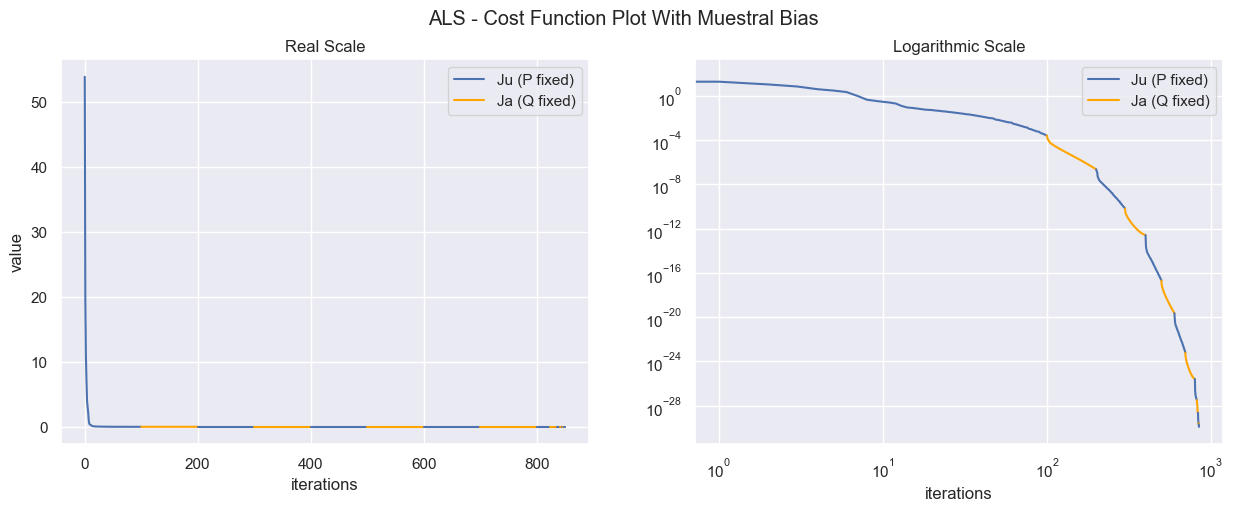

In [24]:
np.random.seed(43)

f = 4
alternations = 1000
tol = 1e-2
max_iter = 1e2

als_result = ALS(
    R,
    f,
    muestral_bias=True,
    alternations=alternations,
    tol=tol,
    max_iter=max_iter,
)

Ju_values = als_result["Ju_values"]
Ja_values = als_result["Ja_values"]
RMSEu_values = als_result["RMSEu_values"]
RMSEa_values = als_result["RMSEa_values"]

plotALSResults(Ju_values, Ja_values, "ALS - Cost Function Plot With Muestral Bias")

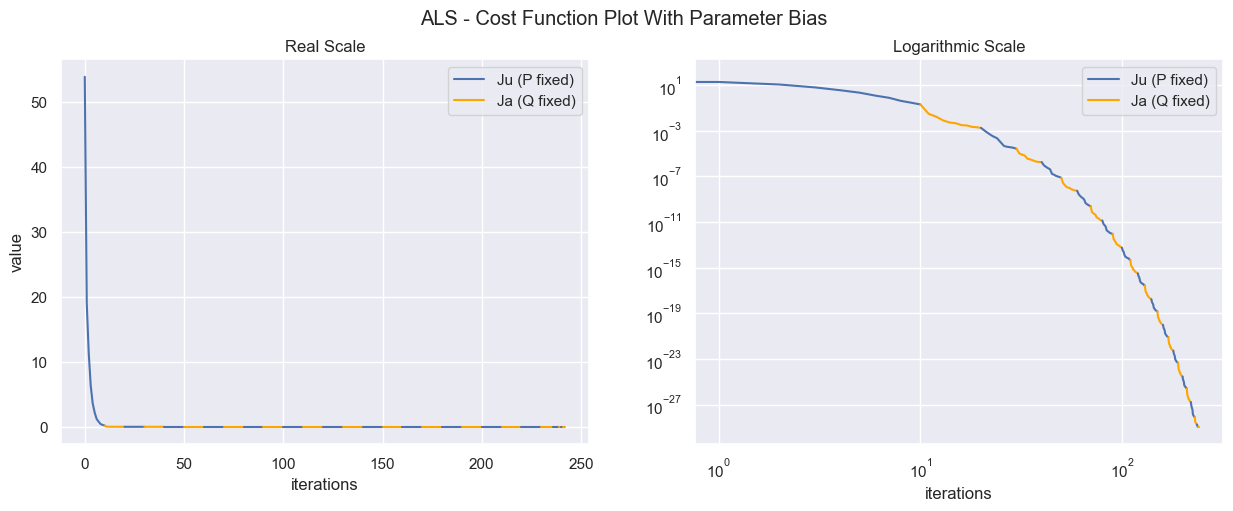

In [29]:
np.random.seed(43)

f = 4
alternations = 1000
tol = 1e-2
max_iter = 1e1

als_result = ALS(
    R,
    f,
    parameter_bias=True,
    alternations=alternations,
    tol=tol,
    max_iter=max_iter,
)

Ju_values = als_result["Ju_values"]
Ja_values = als_result["Ja_values"]
RMSEu_values = als_result["RMSEu_values"]
RMSEa_values = als_result["RMSEa_values"]

plotALSResults(Ju_values, Ja_values, "ALS - Cost Function Plot With Parameter Bias")
